# 1. Setup

In [1]:
from utils import *

# 2. Prepare data

## 2.1. Download

In [2]:
# %%bash
# # t=0:07
# path=../data/nhts
# mkdir -p $path; cd $path
# url="https://nhts.ornl.gov/assets/2016/download/csv.zip"
# wget $url
# unzip csv.zip

## 2.2. Load tables

**[Census division classification](https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf)**

In [3]:
with open('../data/nhts/nhts-codes.yaml', 'r') as f:
    nhts_codes = yaml.safe_load(f)

### 2.2.1. Persons

In [4]:
per = pd.read_csv('../data/nhts/perpub.csv').rename(columns=str.lower).disp()

264,234 rows x 121 cols; Memory: 296.5 MiB


,houseid,personid,r_age,educ,r_hisp,r_relat,r_sex,r_race,prmact,payprof,...,smplsrce,wtperfin,hbhur,hthtnrnt,htppopdn,htresdn,hteempdn,hbhtnrnt,hbppopdn,hbresdn
,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,...,<int64>,<float64>,<object>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>
0,30000007,1,67,3,2,1,2,2,6,2,...,2,206.690153,T,50,1500,750,750,20,750,300


### 2.2.2. Vehicles

In [5]:
veh = pd.read_csv('../data/nhts/vehpub.csv')
print(*veh.columns, sep=', ')
veh = veh.rename(columns=str.lower)[(
    'houseid vehid vehyear vehage make model fueltype vehtype whomain '
    'od_read hfuel vehowned vehownmo annmiles hybrid personid '
).split()].disp(0)

HOUSEID, VEHID, VEHYEAR, VEHAGE, MAKE, MODEL, FUELTYPE, VEHTYPE, WHOMAIN, OD_READ, HFUEL, VEHOWNED, VEHOWNMO, ANNMILES, HYBRID, PERSONID, TRAVDAY, HOMEOWN, HHSIZE, HHVEHCNT, HHFAMINC, DRVRCNT, HHSTATE, HHSTFIPS, NUMADLT, WRKCOUNT, TDAYDATE, LIF_CYC, MSACAT, MSASIZE, RAIL, URBAN, URBANSIZE, URBRUR, CENSUS_D, CENSUS_R, CDIVMSAR, HH_RACE, HH_HISP, HH_CBSA, SMPLSRCE, WTHHFIN, BESTMILE, BEST_FLG, BEST_EDT, BEST_OUT, HBHUR, HTHTNRNT, HTPPOPDN, HTRESDN, HTEEMPDN, HBHTNRNT, HBPPOPDN, HBRESDN, GSYRGAL, GSTOTCST, FEGEMPG, FEGEMPGA, GSCOST, FEGEMPGF
256,115 rows x 16 cols; Memory: 56.9 MiB


,houseid,vehid,vehyear,vehage,make,model,fueltype,vehtype,whomain,od_read,hfuel,vehowned,vehownmo,annmiles,hybrid,personid
,<int64>,<int64>,<int64>,<int64>,<object>,<object>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>


### 2.2.3. Households

In [6]:
hh = pd.read_csv('../data/nhts/hhpub.csv')
print(*hh.columns, sep=', ')
hh = (hh.rename(columns={'HOUSEID': 'hh_id', 'HHSTATE': 'state'})
      .assign(bg_rurality=hh.HBHUR.map(nhts_codes['rurality']))
      .assign(division=hh.CENSUS_D.map(nhts_codes['division']))
      [['hh_id', 'state', 'division', 'bg_rurality']]
      .dropna().reset_index(drop=True)).disp()

HOUSEID, TRAVDAY, SAMPSTRAT, HOMEOWN, HHSIZE, HHVEHCNT, HHFAMINC, PC, SPHONE, TAB, WALK, BIKE, CAR, TAXI, BUS, TRAIN, PARA, PRICE, PLACE, WALK2SAVE, BIKE2SAVE, PTRANS, HHRELATD, DRVRCNT, CNTTDHH, HHSTATE, HHSTFIPS, NUMADLT, YOUNGCHILD, WRKCOUNT, TDAYDATE, HHRESP, LIF_CYC, MSACAT, MSASIZE, RAIL, URBAN, URBANSIZE, URBRUR, SCRESP, CENSUS_D, CENSUS_R, CDIVMSAR, HH_RACE, HH_HISP, HH_CBSA, RESP_CNT, WEBUSE17, SMPLSRCE, WTHHFIN, HBHUR, HTHTNRNT, HTPPOPDN, HTRESDN, HTEEMPDN, HBHTNRNT, HBPPOPDN, HBRESDN
129,587 rows x 4 cols; Memory: 25.0 MiB


,hh_id,state,division,bg_rurality
,<int64>,<object>,<object>,<object>
0,30000007,NC,South Atlantic,Small town


### 2.2.4. Trips

In [7]:
# t=0:08
tripUS = pd.read_csv('../data/nhts/trippub.csv')
print(*tripUS.columns, sep=', ')
tripUS = (tripUS.assign(weekend=tripUS.TDWKND == 1)
        .assign(mode=tripUS.TRPTRANS.map(nhts_codes['mode']))
        .assign(purpose=tripUS.TRIPPURP.map(nhts_codes['purpose']))
        .rename(columns=D(HOUSEID='hh_id', TRVLCMIN='duration', TRPMILES='distance'))
        [['hh_id', 'weekend', 'mode', 'purpose', 'duration', 'distance']]
        .query('duration > 0 & distance > 0 & purpose != "Not Home-Based"')
        .dropna().reset_index(drop=1)
        .merge(hh, on='hh_id')).disp()

HOUSEID, PERSONID, TDTRPNUM, STRTTIME, ENDTIME, TRVLCMIN, TRPMILES, TRPTRANS, TRPACCMP, TRPHHACC, VEHID, TRWAITTM, NUMTRANS, TRACCTM, DROP_PRK, TREGRTM, WHODROVE, WHYFROM, LOOP_TRIP, TRPHHVEH, HHMEMDRV, HH_ONTD, NONHHCNT, NUMONTRP, PSGR_FLG, PUBTRANS, TRIPPURP, DWELTIME, TDWKND, VMT_MILE, DRVR_FLG, WHYTRP1S, ONTD_P1, ONTD_P2, ONTD_P3, ONTD_P4, ONTD_P5, ONTD_P6, ONTD_P7, ONTD_P8, ONTD_P9, ONTD_P10, ONTD_P11, ONTD_P12, ONTD_P13, TDCASEID, TRACC_WLK, TRACC_POV, TRACC_BUS, TRACC_CRL, TRACC_SUB, TRACC_OTH, TREGR_WLK, TREGR_POV, TREGR_BUS, TREGR_CRL, TREGR_SUB, TREGR_OTH, WHYTO, TRAVDAY, HOMEOWN, HHSIZE, HHVEHCNT, HHFAMINC, DRVRCNT, HHSTATE, HHSTFIPS, NUMADLT, WRKCOUNT, TDAYDATE, HHRESP, LIF_CYC, MSACAT, MSASIZE, RAIL, URBAN, URBANSIZE, URBRUR, GASPRICE, CENSUS_D, CENSUS_R, CDIVMSAR, HH_RACE, HH_HISP, HH_CBSA, SMPLSRCE, R_AGE, EDUC, R_SEX, PRMACT, PROXY, WORKER, DRIVER, WTTRDFIN, WHYTRP90, TRPMILAD, R_AGE_IMP, R_SEX_IMP, VEHTYPE, OBHUR, DBHUR, OTHTNRNT, OTPPOPDN, OTRESDN, OTEEMPDN, OBHTNRNT,

,hh_id,weekend,mode,purpose,duration,distance,state,division,bg_rurality
,<int64>,<bool>,<object>,<object>,<int64>,<float64>,<object>,<object>,<object>
0,30000007,False,DRIVE,Other Services,15,5.244,NC,South Atlantic,Small town


In [8]:
tripUS.purpose.value_counts()

purpose
Shopping               193673
Other Services         187752
Work                   115819
Social/Recreational    108391
Name: count, dtype: int64

## 2.3. Prepare data for subregions

In [9]:
tripUS.division.value_counts()

division
South Atlantic        130309
Pacific               127998
West South Central    125774
Mid-Atlantic           86470
East North Central     71803
West North Central     24463
Mountain               23891
New England             9181
East South Central      5746
Name: count, dtype: int64

# 3. Visualize

## 3.1. Trip characteristics by region

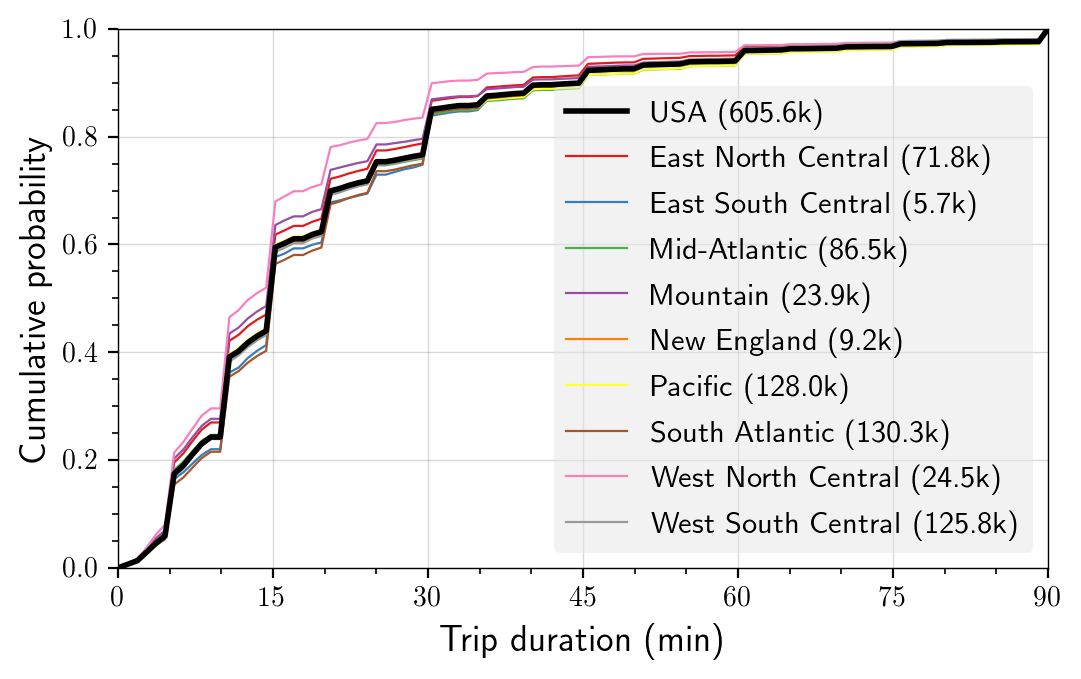

In [10]:
ax = pplot(size=(6, 3.5), xlim=(0, 90), ylim=(0, 1), dpi=200,
           xlab='Trip duration (min)', ylab='Cumulative probability')
# ax.set_title('Trip duration distribution across US region')
def plot_distr(df, label, **kwargs):
    y, x = np.histogram(df['duration'].clip(0, 90), bins=100)
    ax.plot([0] + list(x[1:]), [0] + list((y / y.sum()).cumsum()),
            label=r'{} ({:.1f}k)'.format(label, len(df) / 1e3), **kwargs)
plot_distr(tripUS, color='k', lw=2, ls='-', label='USA', zorder=100)
colors = sns.color_palette('Set1', tripUS['division'].nunique())
for (label, df), color in zip(tripUS.groupby('division'), colors):
    plot_distr(df, lw=0.8, color=color, label=label)
ax.legend()
ax.set_xticks(np.arange(0, 90+1, 15))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5));

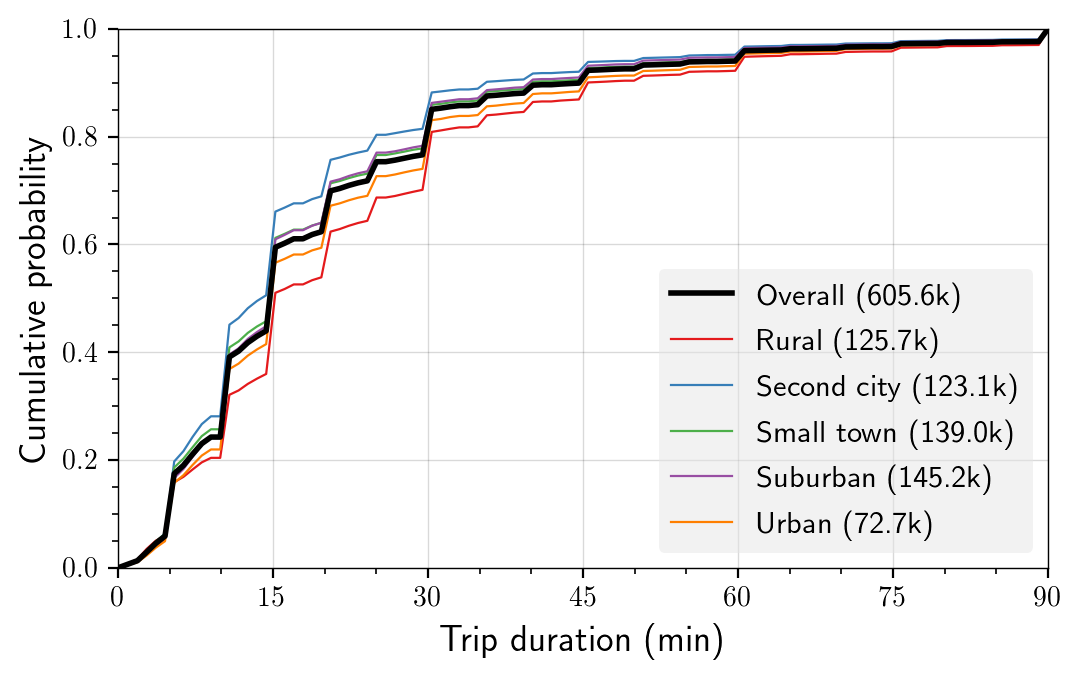

In [11]:
ax = pplot(size=(6, 3.5), xlim=(0, 90), ylim=(0, 1), dpi=200,
           xlab='Trip duration (min)', ylab='Cumulative probability')
# ax.set_title('Trip duration distribution by rurality')
def plot_distr(df, label, **kwargs):
    y, x = np.histogram(df['duration'].clip(0, 90), bins=100)
    ax.plot([0] + list(x[1:]), [0] + list((y / y.sum()).cumsum()),
            label=r'{} ({:.1f}k)'.format(label, len(df) / 1e3), **kwargs)
plot_distr(tripUS, color='k', lw=2, ls='-', label='Overall', zorder=100)
colors = sns.color_palette('Set1', tripUS['bg_rurality'].nunique())
for (label, df), color in zip(tripUS.groupby('bg_rurality'), colors):
    plot_distr(df, lw=0.8, color=color, label=label)
ax.legend()
ax.set_xticks(np.arange(0, 90+1, 15))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5));

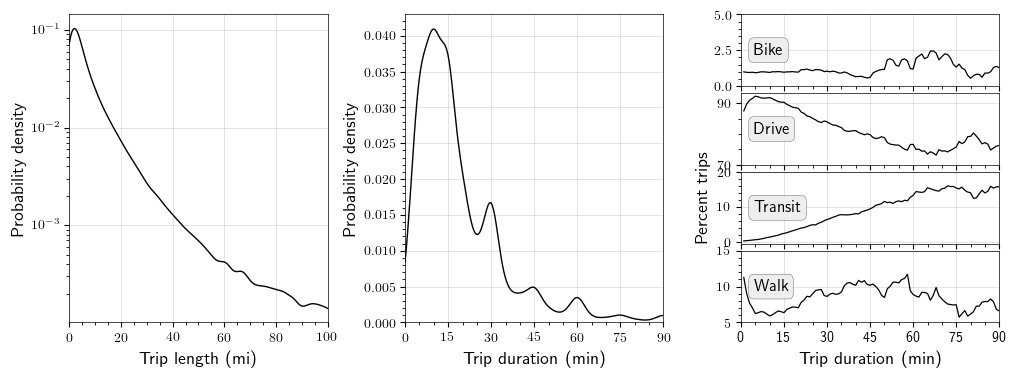

In [12]:
def plot_regional_trip_chars(trip=tripUS, bw_adjust=1.2, dpi=100):
    fig = plt.figure(figsize=(12, 4), dpi=dpi)
    gs = fig.add_gridspec(4, 3, hspace=0.1, wspace=0.3)
    ## Trip length
    ax1 = pplot(fig.add_subplot(gs[:, 0]), xlim=(0, 100), ylog=1,
                xlab='Trip length (mi)', ylab='Probability density')
    sns.kdeplot(trip, ax=ax1, x='distance', bw_adjust=bw_adjust, 
                clip=(0, 100), color='k', lw=1)
    ## Trip duration
    xticks = np.arange(0, 90 + 1, 15)
    ax2 = pplot(fig.add_subplot(gs[:, 1]), xlim=(0, 90),
                xlab='Trip duration (min)', ylab='Probability density')
    sns.kdeplot(trip, ax=ax2, x='duration', bw_adjust=bw_adjust, 
                clip=(0, 90), color='k', lw=1)
    ax2.set_xticks(xticks)
    ax2.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    ## Modal composition by duration
    vmax, smooth = 90, 8
    df = trip.query(f'duration <= {vmax + smooth}')
    df = df.groupby(['mode', 'duration']).size().rename('ntrips')
    df = df.reset_index().pivot_table('ntrips', 'duration', 'mode').fillna(0)
    for i, mode in enumerate(df.columns):
        y = df[mode] / df.sum(1) * 100
        y = y.rolling(smooth).mean()[smooth:]
        y.index = np.arange(1, len(y) + 1)
        ax = fig.add_subplot(gs[i, 2])
        y.plot(ax=ax, color='k', lw=0.9)
        ax.set_xlim(0, 90)
        ax.text(0.05, 0.5, mode.title(), va='center', transform=ax.transAxes,
                fontsize=12, bbox=D(fc='#eee', ec='k', lw=0.2, boxstyle='round'))
        ax.set_xticks(xticks, labels=xticks if i == 3 else [])
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
        ymin, ymax = np.floor(y.min() / 5) * 5, np.ceil(y.max() / 5) * 5
        gap = D(drive=20, transit=10, bike=2.5, walk=5)[mode.lower()]
        ax.set_yticks(np.arange(ymin, ymax + 1, gap))
        if i == 2: ax.set_ylabel('Percent trips', labelpad=5, loc='bottom')
        if i == 3: ax.set_xlabel('Trip duration (min)')

plot_regional_trip_chars() # t=0:10

### 3.1.1. Marginal: By region & mode

In [13]:
tripUS.groupby('mode').duration.describe()

,count,mean,std,min,25%,50%,75%,max
mode,,,,,,,,
BIKE,6338.0,21.598454,26.306736,1.0,10.0,15.0,25.0,435.0
DRIVE,525859.0,21.211675,30.041184,1.0,10.0,15.0,25.0,1200.0
TRANSIT,17184.0,44.204493,36.599954,1.0,20.0,34.0,60.0,690.0
WALK,56254.0,18.856259,27.290807,1.0,5.0,12.0,25.0,1065.0


In [14]:
tripUS.groupby(['mode', 'purpose']).size()

mode     purpose            
BIKE     Other Services           1706
         Shopping                 1099
         Social/Recreational      2318
         Work                     1215
DRIVE    Other Services         152707
         Shopping               181210
         Social/Recreational     84207
         Work                   107735
TRANSIT  Other Services          10638
         Shopping                 1698
         Social/Recreational      1085
         Work                     3763
WALK     Other Services          22701
         Shopping                 9666
         Social/Recreational     20781
         Work                     3106
dtype: int64

In [15]:
mode_colors = D(drive='blue', transit='deeppink', bike='tomato', walk='seagreen')

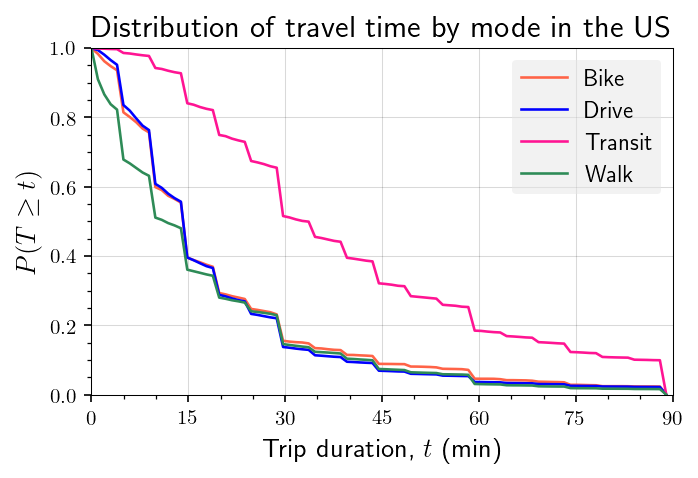

In [16]:
title = 'Distribution of travel time by mode in the US'
ax = pplot(size=(5, 3), title=title, xlab=r'Trip duration, $t$ (min)',
           ylab=r'$P(T\ge t)$', ylim=(0, 1), xlim=(0, 90))
for mode, df in tripUS.groupby('mode'):
    y, x = np.histogram(df['duration'].clip(0, 90), bins=90)
    x = [0] + list(x[:-1])
    y = [1] + list(1 - (y / y.sum()).cumsum())
    ax.plot(x, y, color=mode_colors[mode.lower()], label=mode.title(), lw=1.25)
ax.legend()
ax.set_xticks(np.arange(0, 90 + 1, 15))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5));

### 3.1.2. By purpose

In [17]:
purpose_ls = {'Work': '-', 'Shopping': '--', 'Social/Recreational': '-.', 'Other Services': ':'}

Bike 20.917517252919282
Drive 21.939089035328163
Transit 45.101514505640594
Walk 16.290142324725117


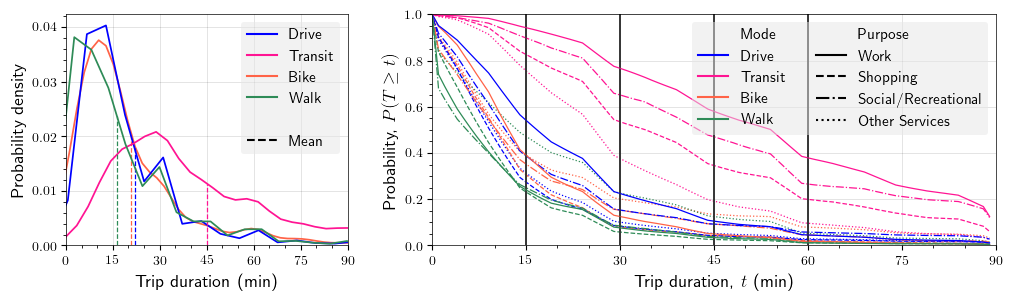

In [18]:
def plot_duration_distr_by_mode_purpose(trip=tripUS, vmax=90, smooth=5, 
                                        linestyles=purpose_ls, 
                                        colors=mode_colors, dpi=100):
    _, axes = plt.subplots(1, 2, figsize=(12, 3), dpi=dpi,
                           gridspec_kw=D(width_ratios=[1, 2]))
    trip = trip.assign(mode=trip['mode'].str.title())
    colors = {k.title(): v for k, v in colors.items()}
    ## (a) Marginal by only mode
    ax1 = pplot(axes[0], xlim=(0, 90))
    # stats = [('Mean', np.mean, '--'), ('Median', np.median, ':')]
    stats = [('Mean', np.mean, '--')]
    for mode, df in trip.groupby('mode'):
        ax1 = sns.kdeplot(df, ax=ax1, x='duration', color=colors[mode], lw=1.25)
        xy = ax1._children[-1]._xy
        for _, func, ls in stats:
            i = np.argwhere(xy[:, 0] < func(df.duration)).flatten()[-1]
            x, y = xy[i:i+2, :].mean(0)
            print(mode, x)
            ax1.plot([x, x], [0, y], color=colors[mode], ls=ls, lw=0.9)
    line = lambda **kw: mpl.lines.Line2D([0], [0], **kw)
    h = ([line(color=c, label=l.title()) for l, c in colors.items()] +
         [line(color='none')] + [line(ls=ls, color='k', label=l) for l, _, ls in stats])
    ax1 = pplot(ax1, xlab='Trip duration (min)', ylab='Probability density')
    ax1.legend(handles=h)
    xticks = np.arange(0, vmax + 1, 15)
    ax1.set_xticks(xticks)
    ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    ## (b) Cumulative by mode & purpose
    ax2 = pplot(axes[1], xlim=(0, 90), ylim=(0, 1),
                 xlab=r'Trip duration, $t$ (min)', ylab=r'Probability, $P(T\ge t)$')
    bins = np.arange(vmax + smooth + 1)
    trip = trip.query('purpose != "Not Home-Based"')
    for purpose, df in trip.groupby('purpose'):
        for mode, df2 in df.groupby('mode'):
            y, x = np.histogram(df2['duration'].clip(0, vmax + smooth), bins=bins)
            x = list(x[smooth + 1:] - x[smooth])
            y = Series(1 - (y / y.sum()).cumsum())
            y = list(y.rolling(smooth, center=True, closed='left').mean()[smooth:])
            ax2.plot([0] + x, [1] + y, lw=0.9, color=colors[mode], ls=linestyles[purpose])
            ax2.set_xticks(xticks)
            for x in [15, 30, 45, 60]:
                ax2.axvline(x, color='#333', lw=0.25)
    ax2.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    ax2.legend(handles=[line(alpha=0, label='Mode')] + 
            [line(color=c, label=l.title()) for l, c in colors.items()] + 
            [line(alpha=0, label='Purpose')] +
            [line(color='k', ls=ls, label=l) for l, ls in linestyles.items()],
            loc='upper right', fontsize=11, ncols=2)

plot_duration_distr_by_mode_purpose()

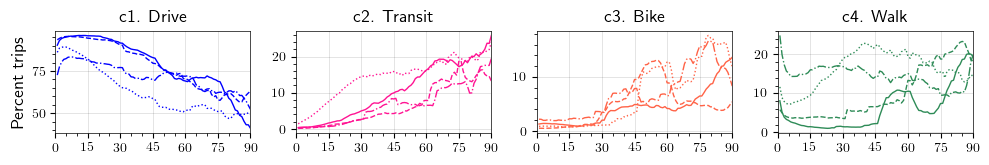

In [19]:
def plot_mode_composition(trip=tripUS, vmax=90, smooth=15, dpi=100,
                          colors=mode_colors, linestyles=purpose_ls):
    _, axes = plt.subplots(1, 4, figsize=(10, 1.75), dpi=dpi)
    trip = (trip.groupby(['mode', 'purpose', 'duration']).size()
            .rename('ntrips').reset_index()
            .pivot_table('ntrips', 'duration', ['mode', 'purpose'])
            .interpolate().fillna(0).reset_index()
            .melt('duration', value_name='ntrips'))
    for purpose, ls in linestyles.items():
        df = trip.query(f'purpose=="{purpose}"')
        df = df.pivot_table('ntrips', 'duration', 'mode')
        for i, (mode, color) in enumerate(colors.items()):
            y = df[mode.upper()] / df.sum(1) * 100
            y = y[y.index <= vmax + smooth][::-1].rolling(smooth).mean()[smooth:][::-1]
            ax = pplot(axes[i], xlim=(0, vmax), ylab='Percent trips' if i == 0 else '')
            ax.set_title(f'c{i+1}. {mode.title()}', fontsize=13)
            y.plot(ax=ax, color=color, ls=ls, lw=1, label=purpose)
            ax.set_xticks(np.arange(0, vmax + 1, 15))
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
            ax.set_xlabel('')
    plt.tight_layout()

plot_mode_composition() # t=0:10

### 3.1.3. Modal composition by duration

In [20]:
# wts = (tripGL.groupby('mode')['duration']
#        .apply(lambda x: np.histogram(x.clip(0, 90), np.arange(0, 92))[0])
#        .explode().rename('n').reset_index()
#        .assign(t=np.tile(np.arange(0, 91), 4))
#        .pivot_table('n', 't', 'mode').fillna(0)
#        .assign(_total=lambda df: df.sum(1)))
# wts = wts.div(wts._total, axis=0).dropna().drop(columns='_total')
# wts.columns = wts.columns.tolist()
# ax = pplot(size=(6, 4), xlim=(1, 90), ylim=(0, 1),
#             ylab='Percent of trips', xlab='Trip duration (min)')
# ax.stackplot(wts.index, *[wts[x] for x in wts], labels=wts.columns, 
#              colors=MODES.color, alpha=0.6)
# ax.legend(loc='center', framealpha=1)
# wts.disp(); pass
# wts.to_csv('../data/nhts/trip-duration-distr-by-mode.csv')

## 3.2. Fit decay functions

### 3.2.1. Select the functional form

In [21]:
import warnings
from scipy.optimize import curve_fit

In [22]:
def fit_decay_func(values, func, method='lm', bin_interval=1):
    bins = np.arange(0, np.max(values) + 1, bin_interval)
    y, x = np.histogram(values, bins=bins)
    x, y = x[1:], 1 - (y / y.sum()).cumsum()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        params = curve_fit(func, x, y, method=method)[0]
        yfit = func(x, *params)
        r2 = 1 - ((yfit - y)**2).sum() / ((y - y.mean())**2).sum()
    return params, r2

In [23]:
def fit_decay_functions(funcs, trips, 
                        cols=(('duration', 90), ('distance', 100))):
    res = []
    for mode, df in trips.groupby('mode'):
        for col, vmax in cols:
            for fname, f in funcs.items():
                params, r2 = fit_decay_func(df[col].clip(0, vmax), f)
                if r2 < 0 or r2 > 1: continue
                res.append(D(func=fname, mode=mode.title(),
                             col=col, r2=r2, params=list(params)))
    return Pdf(res)

funcs = {
    'Power:\n' + r'$x^a$': lambda x, a: x**a,
    'Base exponential:\n' + r'$e^{ax}$': lambda x, a: np.exp(a*x),
    'Quadratic exponential:\n' + r'$e^{ax+bx^2}$': lambda x, a, b: np.exp(a*x - b*(x**2)),
    'Sherratt Tanner:\n' + r'$e^{ax^2}$': lambda x, a: np.exp(-a*(x**2)),
    'Cubic exponential:\n' + r'$e^{ax+bx^2+cx^3}$': lambda x, a, b, c: np.exp(-a*x + b*(x**2) - c*(x**3)),
    'Power exponential:\n' + r'$e^{ax^b}$': lambda x, a, b: np.exp(-a*(x**b)),
    'Tanner:\n' + r'$x^a e^{bx}$': lambda x, a, b: (x**a) * np.exp(b*x),
    'Logistic:\n' + r'$2(1+e^{ax})^{-1}$': lambda x, a: 2*(1+np.exp(a*x))**(-1),
}
fit = fit_decay_functions(funcs, tripUS).disp()

63 rows x 5 cols; Memory: 0.0 MiB


,func,mode,col,r2,params
,<object>,<object>,<object>,<float64>,<object>
0,Power:\n$x^a$,Bike,duration,0.65975,[-0.436504604247452]


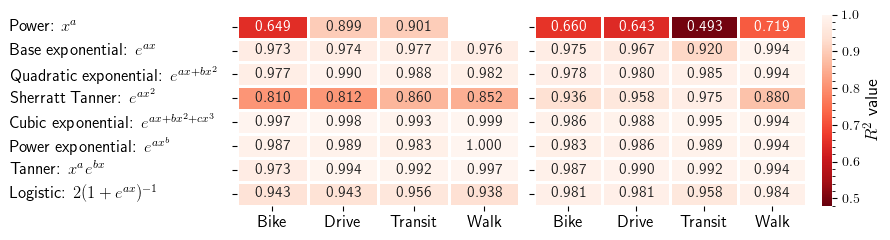

In [24]:
_, axes = plt.subplots(1, 2, figsize=(9, 2.5), dpi=100,
                       gridspec_kw=D(width_ratios=[1, 1.2]))
for i, (col, df) in enumerate(fit.groupby('col')):
    ax = pplot(axes[i], xlab='', ylab='')
    df = df.assign(func=[x.replace('\n', ' ') for x in df.func])
    df = df.pivot_table('r2', 'func', 'mode', sort=False)
    ax = sns.heatmap(df, ax=ax, annot=True, fmt='.3f', cmap='Reds_r', 
                     vmin=0.48, vmax=1, cbar=i == 1, lw=1, cbar_kws=D(
                         label=r'$R^2$ value'), annot_kws=D(fontsize=11))
    if i > 0: ax.set_yticklabels([])
    ax.minorticks_off(); ax.set_xlabel(''); ax.set_ylabel('')
    ax.yaxis.set_tick_params(pad=160)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, ha='left')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.grid(False)
plt.tight_layout()

### 3.2.2. Fit parameters

In [25]:
def fit_params(trips=tripUS, func=lambda x, a, b: np.exp(-a*(x**b)),
               cols=(('duration', 90), ('distance', 100)), overwrite=False):
    outpath = Path('../data/nhts/fitted-params-power-exponential.csv')
    if outpath.exists() and not overwrite:
        return pd.read_csv(outpath)
    res = []
    trips = trips.query('purpose != "Not Home-Based"')
    for col, vmax in cols:
        for mode, df in trips.groupby('mode'):
            (a, b), r2 = fit_decay_func(df[col].clip(0, vmax), func)
            res.append((mode.title(), 'Overall', col.title(), a, b, r2))
            for purpose, df2 in df.groupby('purpose'):
                (a, b), r2 = fit_decay_func(df2[col].clip(0, vmax), func)
                if r2 < 0 or r2 > 1: continue
                res.append((mode.title(), purpose.title(), col.title(), a, b, r2))
    res = Pdf(res, columns=['mode', 'purpose', 'measure', 'alpha', 'beta', 'r2'])
    df = res.melt(['measure', 'mode', 'purpose'], var_name='parameter')
    pivot = df.pivot_table('value', ['mode', 'purpose'], 
                           ['measure', 'parameter'], sort=False)
    disp_table(pivot, [D(selector='td, th', props=[
        ('border', '1px solid grey !important'), ('text-align', 'left')])])
    df.to_csv(mkfile(outpath), index=False)
    return df

x = fit_params(overwrite=1)#; x

In [30]:
def fit_params2(trips=tripUS, func=lambda x, a: np.exp(-a*x),
               cols=(('duration', 90), ('distance', 100))):
    res = []
    trips = trips.query('purpose != "Not Home-Based"')
    for col, vmax in cols:
        for mode, df in trips.groupby('mode'):
            (a,), r2 = fit_decay_func(df[col].clip(0, vmax), func)
            res.append((mode.title(), 'Overall', col.title(), a, r2))
            for purpose, df2 in df.groupby('purpose'):
                (a,), r2 = fit_decay_func(df2[col].clip(0, vmax), func)
                if r2 < 0 or r2 > 1: continue
                res.append((mode.title(), purpose.title(), col.title(), a, r2))
    res = Pdf(res, columns=['mode', 'purpose', 'measure', 'alpha', 'r2'])
    df = res.melt(['measure', 'mode', 'purpose'], var_name='parameter')
    pivot = df.pivot_table('value', ['mode', 'purpose'], 
                           ['measure', 'parameter'], sort=False)
    disp_table(pivot, [D(selector='td, th', props=[
        ('border', '1px solid grey !important'), ('text-align', 'left')])])
    return df

x = fit_params2()#; x

In [25]:
(x.assign(mode=pd.Categorical(x['mode'], categories=['Drive','Transit','Walk','Bike']))
 .assign(purpose=pd.Categorical(x['purpose'], categories=[
     'Overall','Work','Shopping','Social/Recreational','Other Services']))
 [(x.measure == 'Duration') & (x.parameter != 'r2')]
 .pivot_table('value', 'purpose', ['parameter', 'mode'])
 )

parameter               alpha                                    beta  \
mode                    Drive   Transit      Walk      Bike     Drive   
purpose                                                                 
Overall              0.018096  0.002022  0.052866  0.025748  1.328470   
Work                 0.007628       NaN  0.055893  0.007254  1.466800   
Shopping             0.015053  0.001588  0.021661  0.012158  1.469516   
Social/Recreational  0.021972       NaN  0.082771  0.036398  1.230737   
Other Services       0.018876  0.001718  0.030111  0.039438  1.359185   

parameter                                          
mode                  Transit      Walk      Bike  
purpose                                            
Overall              1.617501  1.010898  1.202151  
Work                      NaN  1.079120  1.603613  
Shopping             1.652498  1.401153  1.519313  
Social/Recreational       NaN  0.947031  1.099888  
Other Services       1.754625  1.085209  1.023212